# Problem Set 3, due October 1 at 11:59pm.

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import time
import copy

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

> <font color='red'>Convert into a dataframe:</font>

In [3]:
boston = pd.DataFrame(bdata.data)
boston.columns = bdata.feature_names[:]
boston['MEDV'] = bdata.target

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function (other than sqrt) to compute RMSE.

> <font color='red'>The RMSE equation is:
>
>$$
RMSE = \sqrt{\frac{\sum_{i}^{N}(p_{i} - o_{i})^{2}}{N}}
$$
>
> where $N$ is the number of observations, $p$ is the prediction, and $o$ is the observation.
</font>

In [4]:
def compute_rmse(predictions, yvalues):
    """
    Function
    --------
    Given two arrays, one of actual values and one of predicted values,
    compute the Root Mean Squared Error

    Parameters
    ----------
    predictions : array
        Array of numerical values corresponding to predictions for each of the N observations

    yvalues : array
        Array of numerical values corresponding to the actual values for each of the N observations

    Returns
    -------
    rmse : float
        Root Mean Squared Error of the prediction

    Example
    -------
    >>> print(compute_rmse((2,2,3),(0,2,6)))
    2.08
    """
    # check type of input, and convert to array if necessary
    if type(predictions)!=np.ndarray:
        predictions = np.array(predictions)
    if type(yvalues)!=np.ndarray:
        yvalues = np.array(yvalues)
    
    # do the computation
    rmse = np.sqrt(np.sum((predictions - yvalues)**2)/len(predictions))
    return rmse

> <font color='red'>Reproduce the example:</font>

In [5]:
print('{:.2f}'.format(compute_rmse((2,2,3),(0,2,6))))

2.08


### 1.2 Divide your data into training and testing datasets

Randomly select 80% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 20% in a testing dataset (call this "bdata_test")


In [6]:
# leave the following line untouched, it will help ensure that your "random" split is the same 
# "random" split used by the rest of the class
np.random.seed(seed=13579)

# total observations
total_N = len(boston.index)

# number of training values, rounded to the closest integer
train_N = np.int(np.round(total_N * 0.8))

# number of testing values
test_N = total_N - train_N

# randomly select training indices, sorted
train_inds = np.random.choice(range(total_N), train_N, replace=False)
train_inds = np.sort(train_inds)

# pull out the training and testing datasets
bdata_train = boston.iloc[train_inds].copy()
bdata_test = boston[~boston.index.isin(train_inds)].copy()

# reset the indexes of the dataframes (for intuitive indexing)
bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

### 1.3 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Specifically, do the following:
1. Compute the RMSE of the training set.
2. Now compute the RMSE on the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?

In [7]:
# create the array of predictions for the training dataset (all the same value)
bdata_train_baseline_predicted = np.ones(train_N) * np.mean(bdata_train['MEDV'])

# compute RMSE
train_baseline_RMSE = compute_rmse(bdata_train_baseline_predicted, bdata_train['MEDV'])
print('training RMSE = {:.5f}'.format(train_baseline_RMSE))

training RMSE = 9.20711


In [8]:
# create the array of predictions for the test dataset (all the same value)
# also time it
t_start = time.time()
bdata_test_baseline_predicted = np.ones(test_N) * np.mean(bdata_train['MEDV'])
t_end = time.time()
t_test_baseline = t_end - t_start

# compute RMSE
test_baseline_RMSE = compute_rmse(bdata_test_baseline_predicted, bdata_test['MEDV'])
print('testing RMSE = {:.5f}'.format(test_baseline_RMSE))

testing RMSE = 9.11154


> <font color='red'>As we can see above, the RMSE obtained for the training and testing datasets using this method are approximately identical. This is expected - since the training and test datasets were randomly separated, there should not be any systematic differences between the two (except those created by chance). In other words, the mean and standard deviation of the two datasets should be approximately equal. Therefore, comparing both datasets to the mean of the training dataset is effectively equivalent to comparing each dataset to their own means, and since the standard deviations of the two datasets should also be approximately equal, we should end up with approximately the same RMSE for both.</font>

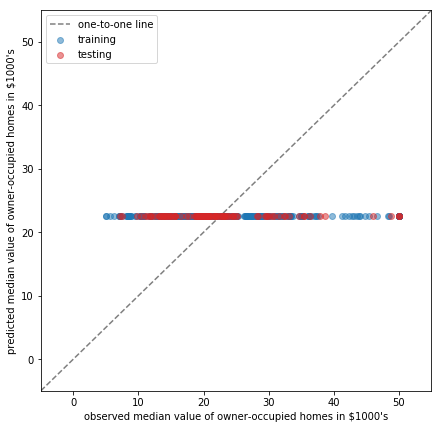

In [9]:
fig, ax = plt.subplots(figsize=(7,7))

# scatter data
ax.scatter(bdata_train['MEDV'], bdata_train_baseline_predicted, c='C0', label='training', alpha=0.5)
ax.scatter(bdata_test['MEDV'], bdata_test_baseline_predicted, c='C3', label='testing', alpha=0.5)

# draw one to one line
ax.plot([-5,55],[-5,55],ls='--',c='C7',zorder=-99,label='one-to-one line')

# prettify
ax.set_xlabel("observed median value of owner-occupied homes in $1000's")
ax.set_ylabel("predicted median value of owner-occupied homes in $1000's")
ax.set_xlim(-5,55)
ax.set_ylim(-5,55)
ax.set_xticks(np.arange(0,51,10))
ax.set_yticks(np.arange(0,51,10))
ax.legend()

plt.show(fig)

In [10]:
print('time to compute the baseline predicted values for the test dataset = {:.5f}s'.format(t_test_baseline))

time to compute the baseline predicted values for the test dataset = 0.00017s


---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).
[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

> <font color='red'>The L-norm distance equation is:
>
>$$
D(x_{1}, x_{2}) = \sqrt[L]{\sum_{m}^{M}(x_{1m} - x_{2m})^{L}}
$$
>
> where $D$ is the L-norm distance, $L$ is the order, and $M$ is the number of dimensions.
>
> Note that I altered the function below to make it more general: `x2` can contain multiple points, in which case the function will compute a distance between `x1` and every point in `x2`.
> 
> Also note that I return the distance(s) as floats instead of integers (I assume the original function description was a typo...)
</font>

In [11]:
def distance(x1, x2, L):
    """
    Given two instances and a value for L, return the L-Norm distance between them

    Parameters
    ----------
    x1 : array
        Coordinates of a point - ROW VECTOR.
        
    x2 : array
        Coordinates of point(s) - COLUMN VECTOR.

    L: int
        Value of L to use in computing distances

    Returns
    -------
    dist : int or array
        The L-norm distance between instances

    Example
    -------
    >>> print(distance((3,4),(6,8),2))
    5
    """
    # check type of input, and convert to array if necessary
    if type(x1)!=np.ndarray:
        x1 = np.array(x1)
    if type(x2)!=np.ndarray:
        x2 = np.array(x2)
        
    # calculate the L-norm distance when x2 has many points in it
    if x2.ndim!=1:
        dist = (np.sum((x1 - x2)**L, axis=1))**(1/L)
        
    # calculate the L-norm distance when x2 has a single point in it
    else:
        dist = (np.sum((x1 - x2)**L))**(1/L)
        
    return dist

> <font color='red'>Reproduce the example:</font>

In [12]:
print('{:.0f}'.format(distance((3,4),(6,8),2)))

5


> <font color='red'>Also check that it works when `x2` has more than 1 point:</font>

In [13]:
distance(np.array([3,4]), np.array([[6,8],[5,7],[2,4]]), 2)

array([5.        , 3.60555128, 1.        ])

### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Make sure to do the following
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

In [14]:
def nneighbor(X_test, Y_test, X_train, Y_train, L, ignore_exact=False):
    """
    Given test points and training points, predict a Y for the test points using a basic nearest neighbour approach.

    Parameters
    ----------
    X_test : array
        Coordinates of the test points - COLUMN VECTOR.
        
    Y_test : array
        Observed values of the test points - ROW VECTOR.
        
    X_train : array
        Coordinates of the training points - COLUMN VECTOR.
        
    Y_train : array
        Observed values of the training points - ROW VECTOR.

    L : int
        Value of L to use in computing distances.
        
    ignore_exact : boolean
        If true, do not count the exact same point as a nearest neighbour.

    Returns
    -------
    Y_test_predicted : array
        Predicted values of the test points.
        
    rmse : float
        RMSE between the predicted and observed values for the test points.
        
    t : float
        Duration (in seconds) to predict the values of the test points (does not include time to compute RMSE).
    """
    # number of test points
    n_x = len(X_test)
    
    # initiate the storage vector for Y_test_predicted
    t_start = time.time()
    Y_test_predicted = np.zeros(n_x)
    
    # loop over points, calculate closest neighbour, and obtain its y-value
    for i in range(n_x):
        dist = distance(X_test[i], X_train, L)
        if ignore_exact:
            Y_test_predicted[i] = Y_train[np.argmin(dist[dist!=0])]
        else:
            Y_test_predicted[i] = Y_train[np.argmin(dist)]
    t_end = time.time()
        
    # RMSE
    rmse = compute_rmse(Y_test_predicted, Y_test)
    
    # t
    t = t_end - t_start
        
    return Y_test_predicted, rmse, t

> <font color='red'>For now, choose $L$ = 2. Also, for the training dataset, do not compare points to themselves, since this would just output a meaningless RMSE of 0.</font>

In [15]:
# for the test dataset
bdata_test_bnn_predicted, test_bnn_RMSE, t_test_bnn = nneighbor(bdata_test[['CRIM','RM']].values,
                                                                bdata_test['MEDV'].values,
                                                                bdata_train[['CRIM','RM']].values,
                                                                bdata_train['MEDV'].values,
                                                                2)

# for the training dataset
bdata_train_bnn_predicted, train_bnn_RMSE, t_train_bnn = nneighbor(bdata_train[['CRIM','RM']].values,
                                                                   bdata_train['MEDV'].values,
                                                                   bdata_train[['CRIM','RM']].values,
                                                                   bdata_train['MEDV'].values,
                                                                   2, ignore_exact=True)

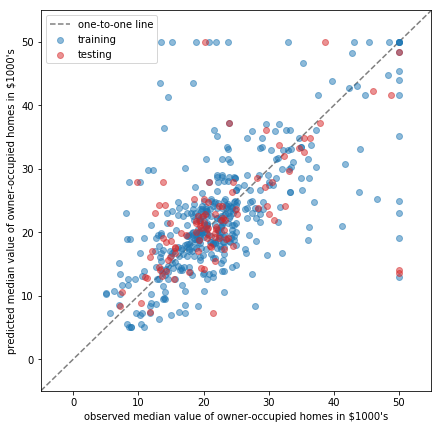

testing RMSE  = 7.72816
training RMSE = 7.98208
---
time to compute the predicted values for the test dataset = 0.00290s
this is 16.9 times slower than for the baseline case.


In [16]:
fig, ax = plt.subplots(figsize=(7,7))

# scatter data
ax.scatter(bdata_train['MEDV'], bdata_train_bnn_predicted, c='C0', label='training', alpha=0.5)
ax.scatter(bdata_test['MEDV'], bdata_test_bnn_predicted, c='C3', label='testing', alpha=0.5)

# draw one to one line
ax.plot([-5,55],[-5,55],ls='--',c='C7',zorder=-99,label='one-to-one line')

# prettify
ax.set_xlabel("observed median value of owner-occupied homes in $1000's")
ax.set_ylabel("predicted median value of owner-occupied homes in $1000's")
ax.set_xlim(-5,55)
ax.set_xticks(np.arange(0,51,10))
ax.set_yticks(np.arange(0,51,10))
ax.set_ylim(-5,55)
ax.legend()

plt.show(fig)

print('testing RMSE  = {:.5f}'.format(test_bnn_RMSE))
print('training RMSE = {:.5f}'.format(train_bnn_RMSE))
print('---')
print('time to compute the predicted values for the test dataset = {:.5f}s'.format(t_test_bnn))
print('this is {:.1f} times slower than for the baseline case.'.format(t_test_bnn/t_test_baseline))

> <font color='red'>As we can see above, this basic nearest neighbours approach using $L$ = 2 and only the `CRIM` and `RM` variables outputs a RMSE of 7.74 for the test dataset, significantly lower than the baseline RMSE of 9.21. Of course this is expected, since the baseline just predicted the average of the entire dataset for every observation, whereas the basic nearest neighbours approach taken here uses the correlation between `CRIM` and `RM` with `MEDV` to estimate `MEDV`. However, the computation required to achieve this decrease in RMSE takes 21 times longer to complete. Also note that the RMSE for the testing dataset is approximately equal to the RMSE for the training dataset when using this nearest neighbours approach. Again, as was explained in part 1, this is expected, since the testing dataset was randomly drawn from the bulk dataset, and so there should be no systematic differences between the testing and training datasets. Further note that `CRIM` and `RM` are not normalized at this stage, which may result in unintentionally weighting the variables differently, since one of the variables may have generally larger values than the other (thus, see below).</font>

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

*NOTE 2*: In this case, there might not be a major impact on RMSE; don't get confused if you find that to be the case.

In [17]:
def normalize(array):
    """
    Normalize an array

    Parameters
    ----------
    array : array
        Original array.

    Returns
    -------
    norm_array : array
        Normalized input array.
    """
    # if the array is just one variable
    if array.ndim==1:
        norm_array = (array - np.mean(array))/np.std(array)
        
    # if more than one variable
    else:
        norm_array = (array - np.mean(array, axis=0))/np.std(array, axis=0)
    
    return norm_array

> <font color='red'>Create normalized dataframes, so we don't have to keep normalizing. But don't normalize `MEDV`, so we can compare our RMSE to the baseline!</font>

In [18]:
bdata_train_norm = bdata_train.copy()
for col in bdata_train.columns:
    if col!='MEDV':
        bdata_train_norm[col] = normalize(bdata_train[col].values)
    
bdata_test_norm = bdata_test.copy()
for col in bdata_test.columns:
    if col!='MEDV':
        bdata_test_norm[col] = normalize(bdata_test[col].values)

In [19]:
# for the test dataset
bdata_test_bnn_predicted, test_bnn_RMSE, t_test_bnn = nneighbor(bdata_test_norm[['CRIM','RM']].values,
                                                                bdata_test_norm['MEDV'].values,
                                                                bdata_train_norm[['CRIM','RM']].values,
                                                                bdata_train_norm['MEDV'].values,
                                                                2)

# for the training dataset
bdata_train_bnn_predicted, train_bnn_RMSE, t_train_bnn = nneighbor(bdata_train_norm[['CRIM','RM']].values,
                                                                   bdata_train_norm['MEDV'].values,
                                                                   bdata_train_norm[['CRIM','RM']].values,
                                                                   bdata_train_norm['MEDV'].values,
                                                                   2, ignore_exact=True)

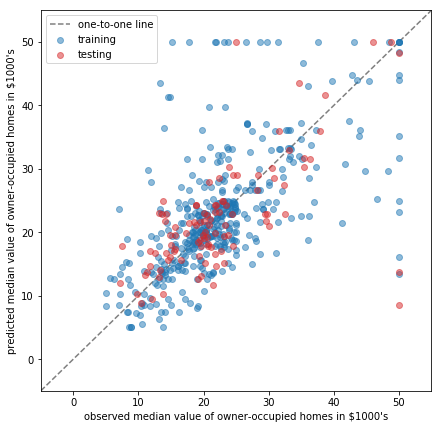

testing RMSE  = 7.56478
training RMSE = 8.21312


In [20]:
fig, ax = plt.subplots(figsize=(7,7))

# scatter data
ax.scatter(bdata_train_norm['MEDV'], bdata_train_bnn_predicted, c='C0', label='training', alpha=0.5)
ax.scatter(bdata_test_norm['MEDV'], bdata_test_bnn_predicted, c='C3', label='testing', alpha=0.5)

# draw one to one line
ax.plot([-5,55],[-5,55],ls='--',c='C7',zorder=-99,label='one-to-one line')

# prettify
ax.set_xlabel("observed median value of owner-occupied homes in $1000's")
ax.set_ylabel("predicted median value of owner-occupied homes in $1000's")
ax.set_xlim(-5,55)
ax.set_xticks(np.arange(0,51,10))
ax.set_yticks(np.arange(0,51,10))
ax.set_ylim(-5,55)
ax.legend()

plt.show(fig)

print('testing RMSE  = {:.5f}'.format(test_bnn_RMSE))
print('training RMSE = {:.5f}'.format(train_bnn_RMSE))

In [21]:
print('RM   : mean = {:.1f}, std = {:.1f}'.format(np.mean(bdata_train['RM']),np.std(bdata_train['RM'])))
print('CRIM : mean = {:.1f}, std = {:.1f}'.format(np.mean(bdata_train['CRIM']),np.std(bdata_train['CRIM'])))

RM   : mean = 6.3, std = 0.7
CRIM : mean = 3.6, std = 8.3


> <font color='red'>After normalizing the variables, the RMSE for both the testing and training datasets are approximately similar to before normalizing the variables. This is because, as shown above, the means and standard deviations of the two variables used here (`RM` and `CRIM`) are roughly similar (i.e. neither of the variables are orders of magnitude different than the other). Therefore, the weighting of these two variables in the L-norm distance calculation was already roughly similar prior to normalization, and thus normalizing did not do much to change the RMSE.</font>

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features

> <font color='red'>A complete optimization process would involve testing every single possible combination of variables with every single possible $L$ (or at least up to some large $L$). For the purposes of this question, I instead choose to optimize within given boundaries:
>
> * only test $L$ = 1, 2, 3 - since, beyond 1, all even powers should behave similarly, and all odd powers should behave similarly
> * fully test combinations of two features
> * fully test combinations of five features
>
> First, the two features approach:
</font>

In [22]:
# create the Ls
Ls = np.array([1,2,3])

# create a list that holds all possible combinations of two features
two_features = []
for i in range(len(bdata.feature_names[:])):
    for j in range(i+1, len(bdata.feature_names[:])):
        two_features.append([bdata.feature_names[i], bdata.feature_names[j]])
        
# storage vectors
two_feature_IDs = np.zeros(len(two_features) * len(Ls))
two_feature_RMSEs = np.zeros(len(two_features) * len(Ls))
two_feature_ts = np.zeros(len(two_features) * len(Ls))
two_feature_Ls = np.zeros(len(two_features) * len(Ls))
two_feature_var1 = []
two_feature_var2 = []

# iterate through the Ls and two_features, storing results as we go
counter = 0
for i in range(len(two_features)):
    for j in range(len(Ls)):
        
        # do the calculation
        Y_test_predicted, rmse, t = nneighbor(bdata_test_norm[[two_features[i][0],two_features[i][1]]].values,
                                              bdata_test_norm['MEDV'].values,
                                              bdata_train_norm[[two_features[i][0],two_features[i][1]]].values,
                                              bdata_train_norm['MEDV'].values,
                                              Ls[j])
        
        # store
        two_feature_IDs[counter] = i
        two_feature_RMSEs[counter] = rmse
        two_feature_ts[counter] = t
        two_feature_Ls[counter] = Ls[j]
        two_feature_var1.append(two_features[i][0])
        two_feature_var2.append(two_features[i][1])
        
        # tick the counter
        counter = counter + 1

# create a dataframe
two_feature_df = pd.DataFrame({'ID':two_feature_IDs,
                               'RMSE':two_feature_RMSEs,
                               't':two_feature_ts,
                               'L':two_feature_Ls,
                               'var1':two_feature_var1,
                               'var2':two_feature_var2})

# find the index with the smallest RMSE
two_feature_min_ind = np.argmin(two_feature_RMSEs)

/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in power


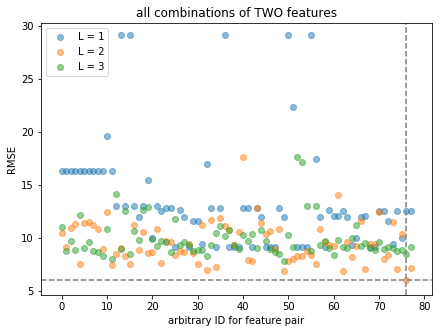

In [23]:
# plot results
fig, ax = plt.subplots(figsize=(7,5))

for i in range(len(Ls)):
    ax.scatter(two_feature_df[two_feature_df['L']==Ls[i]]['ID'],two_feature_df[two_feature_df['L']==Ls[i]]['RMSE'],
               label='L = {}'.format(Ls[i]), color='C'+str(i), alpha=0.5)
    
ax.axhline(two_feature_df['RMSE'][two_feature_min_ind], ls='--', c='C7')
ax.axvline(two_feature_df['ID'][two_feature_min_ind], ls='--', c='C7')

# prettify
ax.set_title('all combinations of TWO features')
ax.legend()
ax.set_xlabel('arbitrary ID for feature pair')
ax.set_ylabel('RMSE')

plt.show(fig)

In [24]:
print('the nearest neighbours run with the smallest RMSE:')
print(' ')
print(two_feature_df.loc[two_feature_min_ind])
print(' ')
print('time to do the optimization = {:.5f}s'.format(np.sum(two_feature_df['t'])))
print('this is {:.1f} times slower than for the baseline case.'.format(np.sum(two_feature_df['t'])/t_test_baseline))

the nearest neighbours run with the smallest RMSE:
 
ID              76
RMSE        6.0234
t       0.00156021
L                2
var1       PTRATIO
var2         LSTAT
Name: 229, dtype: object
 
time to do the optimization = 0.61289s
this is 3585.3 times slower than for the baseline case.


> <font color='red'>As we can see from the analysis above, if we are limiting ourselves to $L$ between 1 and 3 and a combination of two features, `PTRATIO` and `LSTAT`  with $L$ = 2 outperforms every other combination. The obtained RMSE (6.0) is significantly below the RMSE obtained by using `CRIM` and `RM` with $L$ = 2 (7.7), and is far below the baseline RMSE (9.2). However, this of course comes at a computational cost, since we are iterating through all possible combinations of two features.
>
> We next do the same thing, but with five features:</font>

In [25]:
# create the Ls
Ls = np.array([1,2,3])

# create a list that holds all possible combinations of five features
five_features = []
for i in range(len(bdata.feature_names[:])):
    for j in range(i+1, len(bdata.feature_names[:])):
        for k in range(j+1, len(bdata.feature_names[:])):
            for l in range(k+1, len(bdata.feature_names[:])):
                for m in range(l+1, len(bdata.feature_names[:])):
                    five_features.append([bdata.feature_names[i],
                                          bdata.feature_names[j],
                                          bdata.feature_names[k],
                                          bdata.feature_names[l],
                                          bdata.feature_names[m]])
        
# storage vectors
five_feature_IDs = np.zeros(len(five_features) * len(Ls))
five_feature_RMSEs = np.zeros(len(five_features) * len(Ls))
five_feature_ts = np.zeros(len(five_features) * len(Ls))
five_feature_Ls = np.zeros(len(five_features) * len(Ls))
five_feature_var1 = []
five_feature_var2 = []
five_feature_var3 = []
five_feature_var4 = []
five_feature_var5 = []

# iterate through the Ls and five_features, storing results as we go
counter = 0
for i in range(len(five_features)):
    for j in range(len(Ls)):
        
        # do the calculation
        Y_test_predicted, rmse, t = nneighbor(bdata_test_norm[[five_features[i][0],
                                                               five_features[i][1],
                                                               five_features[i][2],
                                                               five_features[i][3],
                                                               five_features[i][4]]].values,
                                              bdata_test_norm['MEDV'].values,
                                              bdata_train_norm[[five_features[i][0],
                                                                five_features[i][1],
                                                                five_features[i][2],
                                                                five_features[i][3],
                                                                five_features[i][4]]].values,
                                              bdata_train_norm['MEDV'].values,
                                              Ls[j])
        
        # store
        five_feature_IDs[counter] = i
        five_feature_RMSEs[counter] = rmse
        five_feature_ts[counter] = t
        five_feature_Ls[counter] = Ls[j]
        five_feature_var1.append(five_features[i][0])
        five_feature_var2.append(five_features[i][1])
        five_feature_var3.append(five_features[i][2])
        five_feature_var4.append(five_features[i][3])
        five_feature_var5.append(five_features[i][4])
        
        # tick the counter
        counter = counter + 1

# create a dataframe
five_feature_df = pd.DataFrame({'ID':five_feature_IDs,
                                'RMSE':five_feature_RMSEs,
                                't':five_feature_ts,
                                'L':five_feature_Ls,
                                'var1':five_feature_var1,
                                'var2':five_feature_var2,
                                'var3':five_feature_var3,
                                'var4':five_feature_var4,
                                'var5':five_feature_var5})

# find the index with the smallest RMSE
five_feature_min_ind = np.argmin(five_feature_RMSEs)

/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in power


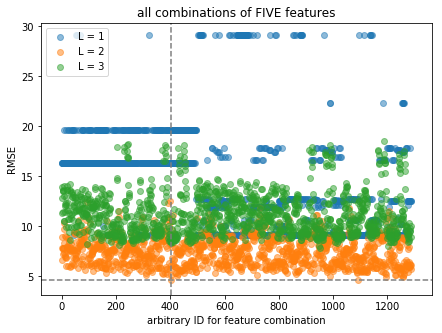

In [26]:
# plot results
fig, ax = plt.subplots(figsize=(7,5))

# colormap the lines
colors = plt.cm.magma(np.linspace(0,0.9,len(Ls)))
for i in range(len(Ls)):
    ax.scatter(five_feature_df[five_feature_df['L']==Ls[i]]['ID'],five_feature_df[five_feature_df['L']==Ls[i]]['RMSE'],
               label='L = {}'.format(Ls[i]), color='C'+str(i), alpha=0.5)
    
ax.axhline(five_feature_df['RMSE'][five_feature_min_ind], ls='--', c='C7')
ax.axvline(five_feature_df['ID'][five_feature_min_ind], ls='--', c='C7')

# prettify
ax.set_title('all combinations of FIVE features')
ax.legend()
ax.set_xlabel('arbitrary ID for feature combination')
ax.set_ylabel('RMSE')

plt.show(fig)

In [27]:
print('the nearest neighbours run with the smallest RMSE:')
print(' ')
print(five_feature_df.loc[five_feature_min_ind])
print(' ')
print('time to do the optimization = {:.5f}s'.format(np.sum(five_feature_df['t'])))
print('this is {:.1f} times slower than for the baseline case.'.format(np.sum(five_feature_df['t'])/t_test_baseline))

the nearest neighbours run with the smallest RMSE:
 
ID             403
RMSE       4.63283
t       0.00172591
L                2
var1          CRIM
var2           NOX
var3           AGE
var4       PTRATIO
var5         LSTAT
Name: 1210, dtype: object
 
time to do the optimization = 13.94956s
this is 81602.1 times slower than for the baseline case.


> <font color='red'>As we can see from the analysis above, if we are limiting ourselves to $L$ between 1 and 3 and a combination of five features, the combination of `CHAS`, `NOX`, `PTRATIO`, `B`, and `LSTAT` with $L$ = 2 returns the lowest RMSE. This RMSE (4.7) is significantly below that obtained from the two feature optimization (6.0). Again, however, there is a significant computational cost as we have to iterate through more combinations. The calculation of distance also takes longer, since there are more dimensions.
>
> There are two points worth noting from the comparison between the two feature and five feature optimization. First, the best performing five features includes the best perfoming two features, and using five features generally outputs a lower RMSE than using two features. Together, this suggests that there are more than two features in the dataset that correlate well with `MEDV`, and so taking many of these into account improves our prediction of `MEDV`. Second, using $L$ = 2 seems to consistently outperform $L$ = 1 or 3, which suggests that the weighting created by using the square power is optimal for this dataset. However, we note that there is a strong possibility that we are overfitting our data by using five rather than two features, as discussed below.</font>

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations. What do you observe?
[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [28]:
# number of values in each fold
fold10_N = np.int(total_N / 10)

# randomly select fold indices
fold10_inds = np.random.choice(range(total_N), (10, fold10_N), replace=False)

# normalize the full dataset
bdata_norm = boston.copy()
for col in bdata_norm.columns:
    if col!='MEDV':
        bdata_norm[col] = normalize(boston[col].values)

# assign the folds
for i in range(10):
    bdata_norm.loc[fold10_inds[i], 'fold'] = i+1
    
# storage vectors
RMSE_cv = np.zeros(10)
t_cv = np.zeros(10)

# iterate through the folds
for i in range(10):
    
    # do the nearest neighbour
    Y_test_predicted, rmse, t = nneighbor(bdata_norm[bdata_norm['fold']==(i+1)][['CRIM','RM']].values,
                                          bdata_norm[bdata_norm['fold']==(i+1)]['MEDV'].values,
                                          bdata_norm[bdata_norm['fold']!=(i+1)][['CRIM','RM']].values,
                                          bdata_norm[bdata_norm['fold']!=(i+1)]['MEDV'].values,
                                          2)
    
    # store
    RMSE_cv[i] = rmse
    t_cv[i] = t

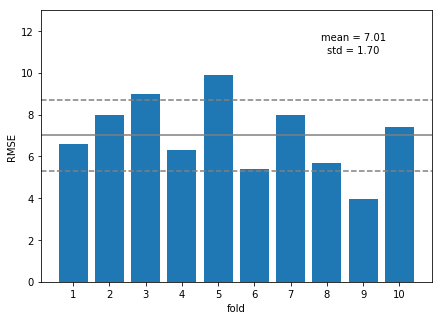

In [29]:
# plot
fig, ax = plt.subplots(figsize=(7,5))

# the RMSE's
ax.bar(np.arange(10)+1, RMSE_cv)

# the mean and standard deviation
mean_RMSE_cv = np.mean(RMSE_cv)
std_RMSE_cv = np.std(RMSE_cv)
ax.axhline(mean_RMSE_cv, c='C7')
ax.axhline(mean_RMSE_cv+std_RMSE_cv, c='C7', ls='--')
ax.axhline(mean_RMSE_cv-std_RMSE_cv, c='C7', ls='--')
ax.text(0.8,0.9,'mean = {:.2f}'.format(mean_RMSE_cv),
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.8,0.85,'std = {:.2f}'.format(std_RMSE_cv),
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax.set_xlabel('fold')
ax.set_ylabel('RMSE')
ax.set_xticks(np.arange(10)+1)
ax.set_ylim(0,13)

plt.show(fig)

In [30]:
print('time to do the cross-validation = {:.5f}s'.format(np.sum(t_cv)))

time to do the cross-validation = 0.00903s


> <font color='red'>As we can see from the cross-validation analysis above, the average RMSE obtained using the cross-validation approach (7.02) is slightly better than the RMSE obtained from using the original testing and training datasets in part 2.3 (7.65). This suggests that the original random split between the testing and training datasets just happened to underestimate (by chance) the average performance of using `CRIM` and `RM` to estimate `MEDV`. 
>
> However, we can also see that there is a relatively large standard deviation on RMSE (1.70) from each of the folds in the cross-validation approach. In fact, by chance, the lowest RMSE obtained on fold 9 (3.96) is the best RMSE obtained so far, including those obtained via optimization in part 2.4. Furthermore, by chance, the highest RMSE obtained on fold 5 (9.89) is the worst RMSE obtained so far, including the bad baseline in part 1.3. This suggests that using `CRIM` and `RM` to estimate `MEDV` with $L$ = 2 is far from optimal for this dataset. In other words, `CRIM` and `RM` do not predict `MEDV` well consistently using the basic nearest neighbours approach (i.e. there are outliers that can skew results significantly), and thus is sensitive to the slice of the data that we use as our training data.
>
> Of course, doing the 10 fold cross validation is more computationally expensive (i.e. it takes more time) than just computing the RMSE for a single test/train split.</font>

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

In [31]:
def knneighbor(X, Y, folds, L, K):
    """
    Using 10-fold cross-validation, compute the RMSE for K nearest neighbours.

    Parameters
    ----------
    X : array
        Coordinates of the points - COLUMN VECTOR.
        
    Y : array
        Observed values of the points - ROW VECTOR.
        
    folds : array
        Fold number for the points (1-10) - ROW VECTOR.

    L : int
        Value of L to use in computing distances.
        
    K : int
        Value of K to use in K nearest neighbours.

    Returns
    -------
    mean_rmse : float
        Mean RMSE of all 10 folds between the predicted and observed values.
        
    std_rmse : float
        Standard deviatio of the RMSE of all 10 folds between the predicted and observed values.
        
    t : float
        Duration (in seconds) to run the whole algorithm (including computing RMSE).
    """
    # start the stopwatch
    t_start = time.time()
    
    # storage vector for the RMSEs
    RMSEs = np.zeros(10)
    
    # iterate through the folds
    for i in range(10):

        # pull out the test and train for this particular fold
        X_train = X[folds!=(i+1)]
        Y_train = Y[folds!=(i+1)]
        X_test = X[folds==(i+1)]
        Y_test = Y[folds==(i+1)]
        
        # number of test points
        n_x = len(X_test)
        
        # initiate the storage vector
        Y_test_predicted = np.zeros(n_x)
        
        # loop over points and obtain its y-value
        for j in range(n_x):
            
            # calculate distance to all other points
            dist = distance(X_test[j], X_train, L)
            
            # calculate the mean Y of the K nearest points
            Y_test_predicted[j] = np.mean(Y_train[dist.argsort()[:K]])
            
        # RMSE
        RMSEs[i] = compute_rmse(Y_test_predicted, Y_test)
        
    t_end = time.time()
        
    # output
    mean_rmse = np.mean(RMSEs)
    std_rmse = np.std(RMSEs)
    t = t_end - t_start
    
    return mean_rmse, std_rmse, t

> <font color='red'>Use `CRIM` and `RM` as in part 2.5:</font>

In [32]:
mean_rmse, std_rmse, t = knneighbor(bdata_norm[['CRIM','RM']].values,
                                    bdata_norm['MEDV'].values,
                                    bdata_norm['fold'].values,
                                    2, 3)

print('mean RMSE = {:.2f}'.format(mean_rmse))
print('std RMSE  = {:.2f}'.format(std_rmse))
print('run time  = {:.5f}s'.format(t))

mean RMSE = 5.70
std RMSE  = 1.27
run time  = 0.02587s


> <font color='red'>The RMSE obtained when using the K-nearest neighbours approach with cross validation (5.70) is smaller than the RMSE obtained when using the single nearest neighbours approach with cross validation (7.02). This can be explained by the fact that taking the mean of K-nearest neighbours dampens the effect of outliers, and thus should reduce their influence on incorrectly predicting `MEDV`. The standard deviation of the RMSEs obtained when using the K-nearest neighbours approach with cross validation (1.26) is also significantly smaller than the standard deviation of the RMSEs obtained when using the single nearest neighbours approach with cross validation (1.70). Again, this can be explained by the dampening effect of K-nearest neighbours on outliers.</font>

### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [33]:
# storage vectors
K_RMSE_means = np.zeros(25)
K_RMSE_stds = np.zeros(25)

# loop over the Ks
for i in range(25):
    mean_rmse, std_rmse, t = knneighbor(bdata_norm[['CRIM','ZN','RM','AGE','DIS','TAX']].values,
                                        bdata_norm['MEDV'].values,
                                        bdata_norm['fold'].values,
                                        2, i+1)
    
    # store
    K_RMSE_means[i] = mean_rmse
    K_RMSE_stds[i] = std_rmse

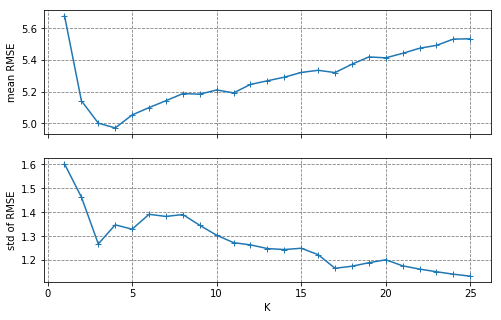

In [34]:
# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,5), sharex=True)

ax[0].plot(np.arange(1,26), K_RMSE_means, '+-')
ax[0].set_ylabel('mean RMSE')
ax[0].grid(ls='--', c='C7')

ax[1].plot(np.arange(1,26), K_RMSE_stds, '+-')
ax[1].set_ylabel('std of RMSE')
ax[1].grid(ls='--', c='C7')

ax[1].set_xlabel('K')

plt.show(fig)

> <font color='red'>As we can see from the plot above, as we increase K initially, the mean RMSE falls quickly and reaches a minimum when K = 4. After that point, increasing K effectively monotonically increases the mean RMSE. This increasing RMSE after K = 4 is expected, since averaging `MEDV` between more and more distant points becomes less and less representative of the `MEDV` of the test point. However, of course, as discussed in part 2.6, there is a benefit of using a small K that is not 1, since this averages out (or dampens) the effect of outliers. Therefore, this suggests that using K = 4 is optimal when trying to predict `MEDV` using the K nearest neighbours approach with `CRIM`, `ZN`, `RM`, `AGE`, `DIS`, and `TAX` as the predictive features.
>
> However, we can also make use of the standard deviation of the 10 folds for each K. As we can see from the plot above, the standard deviation decreases until K = 3, then increases slightly until K = 8, then decreases effectively monotonically. The monotonic decrease after K = 8 can be explained by the fact that averaging over large numbers of points smooths out any variance that could be generated when using a small K. However, the local minima at K = 3 is more difficult to explain precisely. At face value, it suggests that using K = 3 has the most consistent predictive power for any K less than ~10.
>
> Therefore, in my opinion, arguments can be made for using either K = 3 or 4. If we select K = 3, we are prioritizing generalizability (or consistency) over accuracy. If we select K = 4, we are prioritizing  accuracy over generalizability. However, in reality the difference between the mean RMSE and standard deviation of the RMSEs for K = 3 and 4 is very small (perhaps even statistically insignificant), and thus there should be very little difference between the two. If I had to select a single value, I would choose K = 3, since I am of the opinion that consistency is critical, and there is basically no difference in mean RMSE between K = 3 and 4.</font>

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

> <font color='red'>The code below starts with no features, then selects the single best performing feature (i.e. the feature that produces the lowest RMSE). To do so, for each feature, I perform 10-fold cross-validation K nearest neighbours for values of K between 1 and 25, selecting the best performing K. Once the first feature is selected, I combine this first feature with one of the remaining features that produces the lowest RMSE, using exactly the same process that was used to select the first feature. I continue this forward selection algorithm until I have used all features. Note that I fix $L$ at 2 based on the results of part 2.4, but I acknowledge that the optimal value for $L$ may be dependent on K and the number/combination of features being used (I did not explicitly test for this because it was taking a while to run on my computer).</font>

In [35]:
n_features = len(bdata.feature_names[:])

# storage vector for RMSE
feature_RMSEs = np.zeros(n_features)

# storage vector for K
feature_Ks = np.zeros(n_features)

# storage list for features
feature_list = []

# on each iteration, add a feature
for i in range(n_features):
    
    # storage vector for each step of the forward selection
    trial_RMSEs = np.array([])
    
    # this list indexes each feature that is being tested
    trial_feature_list = []
    
    # on each iteration, check another feature
    for j in range(n_features):
        
        # only do the trial if the feature is not already in the feature list
        if bdata.feature_names[j] not in feature_list:
            
            # this list is for actual input into KNN
            trial_features = copy.deepcopy(feature_list)
            trial_features.append(bdata.feature_names[j])
            
            # storage vector for finding optimal K
            K_RMSEs = np.zeros(25)
            
            # on each iteration, check all K's up to 25
            for k in range(25):
                mean_rmse, std_rmse, t = knneighbor(bdata_norm[trial_features].values,
                                                    bdata_norm['MEDV'].values,
                                                    bdata_norm['fold'].values,
                                                    2, k+1)
                
                # store for each K
                K_RMSEs[k] = mean_rmse
                
            # get the minimum K and RMSE
            min_K = np.argmin(K_RMSEs)
            trial_RMSEs = np.append(trial_RMSEs, K_RMSEs[min_K])
            
            # add to trial_feature_list
            trial_feature_list.append(bdata.feature_names[j])
            
    # find the optimal feature to add
    min_RMSE = np.argmin(trial_RMSEs)
    
    # store
    feature_RMSEs[i] = trial_RMSEs[min_RMSE]
    feature_Ks[i] = min_K+1
    feature_list.append(trial_feature_list[min_RMSE])

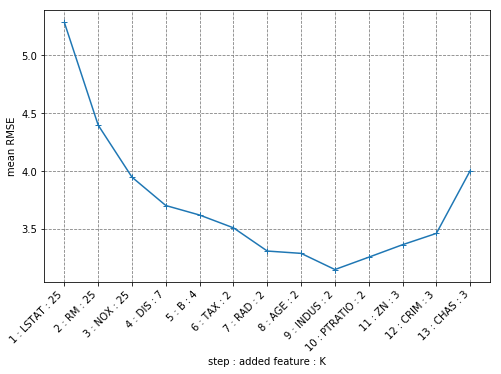

In [36]:
# create x-tick labels
x_tick_labels = []
for i in range(n_features):
    x_tick_labels.append('{} : {} : {:.0f}'.format(i+1, feature_list[i], feature_Ks[i]))

# plot
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(np.arange(n_features), feature_RMSEs, '+-')
ax.set_xticks(np.arange(n_features))
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
ax.grid(ls='--', c='C7')
ax.set_ylabel('mean RMSE')
ax.set_xlabel('step : added feature : K')

plt.show(fig)

> <font color='red'>The plot above is interesting in many regards. First, it is not until step 4 that a K less than 25 is calculated to be optimal (optimal values of K are shown in the x-axis ticks). This suggests that the combination of three features produces many outliers (in terms of predicting `MEDV`) that need to be smoothed out to get a good estimate of `MEDV`. However, once we reach a combination of four features, we appear to lose the large influence of outliers, presumably because, from a point by point perspective, a combination of four features does a much better job of predicting `MEDV` than a combination of three features.
>
> Second, after step 4, the optimal K continues to fall until a value of 2, before increasing to 3 for the final few steps. This can be explained by the fact that continuing to add features is continuing to increase the predictive power of the model until step 9, before the addition of more features weakens the predictive power of the model. There is a possibility that a combination of nine features is overfitting the data, but since we are cross-validating we should be mitigating the risk of this happening. After step 9, it is likely that the remaining variables do not correlate well with `MEDV`, and thus adding them to the model effectively just adds noise that weakens the predictive power of the model.
>
> Ultimately, the lowest RMSE achieved is 3.15 using 9 features, significantly lower than all other RMSEs computed in this problem set. Considering that the standard deviation of all `MEDV` in the dataset is 9.18, this is a reasonable model for predicting `MEDV`. The model could potentially be improved by exploring how different $L$ affects the RMSE for different K and combination of features. We could also explore if weighting the features differently improves RMSE.</font>